In [48]:
# Copyright 2019 The Optcom Authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction

Welcom to Optcom ! This first tutorial introduces the building blocks used to create and run an optical system. The reader is assumed to be familiar with optics and optical system network. An introduction to those topics can be found [here](https://www.elsevier.com/books/nonlinear-fiber-optics/agrawal/978-0-12-397023-7).

## Short word on Optcom's architecture

An optical system in Optcom is created by linking ports of components to each other in a layout. The components represent physical components such as lasers, fibers and so on. Each component is composed of ports where a field can get either in or out, or even both. The layout allows to connect those component's ports to each other and run the simulation, i.e. propagate a field.


## Let's build our first optical system !

This section will guide us step by step in order to create and run a simulation. For our first example, we consider the following system:


     Gaussian Pulse 1 ______
                            \
                             \_____ Amplifier _____ Phase Modulator ____ [output]
                             /
     Gaussian Pulse 2 ______/



### Setup

In [3]:
pip install optcom

Note: you may need to restart the kernel to use updated packages.


In [12]:
import math
import optcom as oc

### Domain
The first step to build an optical system is to build an object Domain which will contain basic physic and computational parameters that will be shared by all components inside a Layout.

In [6]:
domain = oc.Domain(bits=1, bit_width=100.0, samples_per_bit=512)

We have just defined a time window of 100 ps, which is equal to (bits * bit_width). And we consider 512 time points inside this time window. 

### Layout
Now we define a layout which will link the component's ports to each other and propagate the domain and the fields
through the components.

In [7]:
layout = oc.Layout(domain)

### Component
Let's now create the basic components inside our system. A component represent an electric or optical physical block such as an amplifier, phase modulator, fiber and so on. There are two types of components, the ones that create a field and can launch the simulation such as a Gaussian pulse generator and the ones which transform an existing field such as an amplifier.

Let's first create two Gaussian pulses, one centered at 1550 nm with a width of 10 ps and another one centered at 1540 nm with a width of 5 ps, both with a peak power of 1 W.

In [34]:
gaussian_1 = oc.Gaussian(name='Gaussian 1', channels=1, center_lambda=[1550.], width=[10.], peak_power=[1.])
gaussian_2 = oc.Gaussian(name='Gaussian 2', channels=1, center_lambda=[1540.], width=[5.], peak_power=[1.])

Now let's create an amplifier with a 3 dB gain and a phase modulator with a phase shift of $\frac{\pi}{2}$.

In [35]:
amplifier = oc.IdealAmplifier(gain=3.0)
phase_mod = oc.IdealPhaseMod(phase_shift=math.pi/2.0)

The last component we need is a combiner in order to join the two Gaussian pulses before the amplifier.

In [36]:
combiner = oc.IdealCombiner(arms=2)

### Building and Running
We now have everything we need to start building our system. To do so we add links between the ports of the components by chance of the layout. A diagram of the port numbers for each component is available in the Optcom's [documentation](https://optcom.readthedocs.io/en/latest/optcom.components.html). The port of a component can be reached by the method `get_port(port_num)` or simply by object indexing, examples for both are shown below.


In [37]:
layout.reset()
layout.add_link(gaussian_1.get_port(0), combiner.get_port(0))
layout.add_link(gaussian_2[0], combiner[1])
layout.add_links((combiner[2], amplifier[0]), (amplifier[1], phase_mod[0]))

We are now ready to lauch the simulation ! We can specify which pulses we want to launch, or simply run all of them. In order to print the log and follow the path of the fields in the layout, the print log flag can be set 
to True before running the simulation.

In [49]:
oc.set_print_log(True)
# layout.run(gaussian_1, gaussian_2)
layout.run_all()

-------------------------------------------------------------------------------
Component 'Gaussian 1' has sent a signal from port 0 to port 0 of component 'Ideal Combiner 1'.
Signal is waiting for fields arriving at other ports.
-------------------------------------------------------------------------------
Component 'Gaussian 2' has sent a signal from port 0 to port 1 of component 'Ideal Combiner 1'.
-------------------------------------------------------------------------------
Component 'Ideal Combiner 1' has sent a signal from port 2 to port 0 of component 'Ideal Amplifier 2'.
Signal is waiting for copropagating fields.
-------------------------------------------------------------------------------
Component 'Ideal Combiner 1' has sent a signal from port 2 to port 0 of component 'Ideal Amplifier 2'.
-------------------------------------------------------------------------------
Component 'Ideal Amplifier 2' has sent a signal from port 1 to port 0 of component 'Ideal Phase Modulato

### Result and plotting
Optcom offers helper functions to plot propagated fields. Let's plot the temporal power of the original pulses, and the pulses at the end of the simulation, i.e. at the output of the phase modulator.

We first need to gather the data. The components that start the simulation as well that the components that terminate the simulation automatically save their output fields in the corresponding ports. This can be accessed by chance of the attribute fields of every ports. Then, the channels, noises and other field's characteristics can be accessed.

In [39]:
time_data = [gaussian_1[0].fields[0].time,
             gaussian_2[0].fields[0].time,
             phase_mod[1].fields[0].time,
             phase_mod[1].fields[1].time]
power_data = [oc.temporal_power(gaussian_1[0].fields[0].channels),
              oc.temporal_power(gaussian_2[0].fields[0].channels),
              oc.temporal_power(phase_mod[1].fields[0].channels),
              oc.temporal_power(phase_mod[1].fields[1].channels)]

We now can plot the data, we will give some lables to the different plots, some titles and we will gather the 2
first data together as well as the two last data.

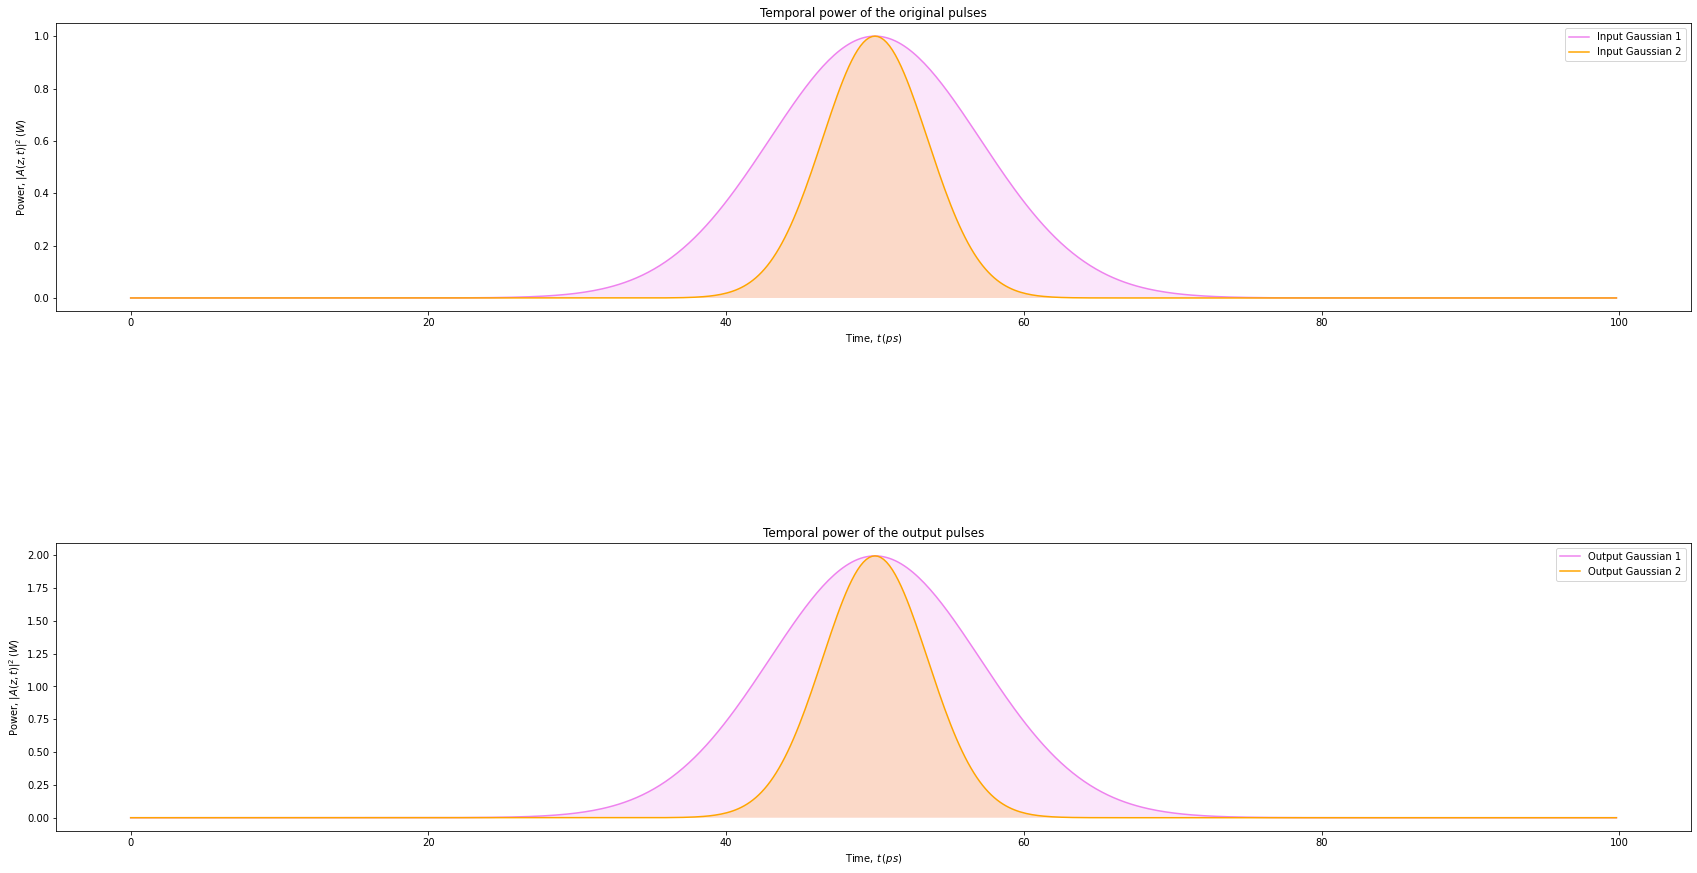

In [43]:
oc.plot2d(time_data, power_data, x_labels=['t'], y_labels=['P_t'], plot_groups=[0,0,1,1],
          plot_titles=['Temporal power of the original pulses', 'Temporal power of the output pulses'],
          plot_labels=['Input Gaussian 1', 'Input Gaussian 2', 'Output Gaussian 1', 'Output Gaussian 2'])

We can see that the time window is indeed 100 ps and the pulses have the pre-defined characteristics. Moreover,  the 3 db amplifier doubled the power of our pulses. 

Let's now do the same with the phase of our pulses to see the effect of the phase modulator.

In [44]:
time_data = [gaussian_1[0].fields[0].time,
             gaussian_2[0].fields[0].time,
             phase_mod[1].fields[0].time,
             phase_mod[1].fields[1].time]
power_data = [oc.temporal_phase(gaussian_1[0].fields[0].channels),
              oc.temporal_phase(gaussian_2[0].fields[0].channels),
              oc.temporal_phase(phase_mod[1].fields[0].channels),
              oc.temporal_phase(phase_mod[1].fields[1].channels)]

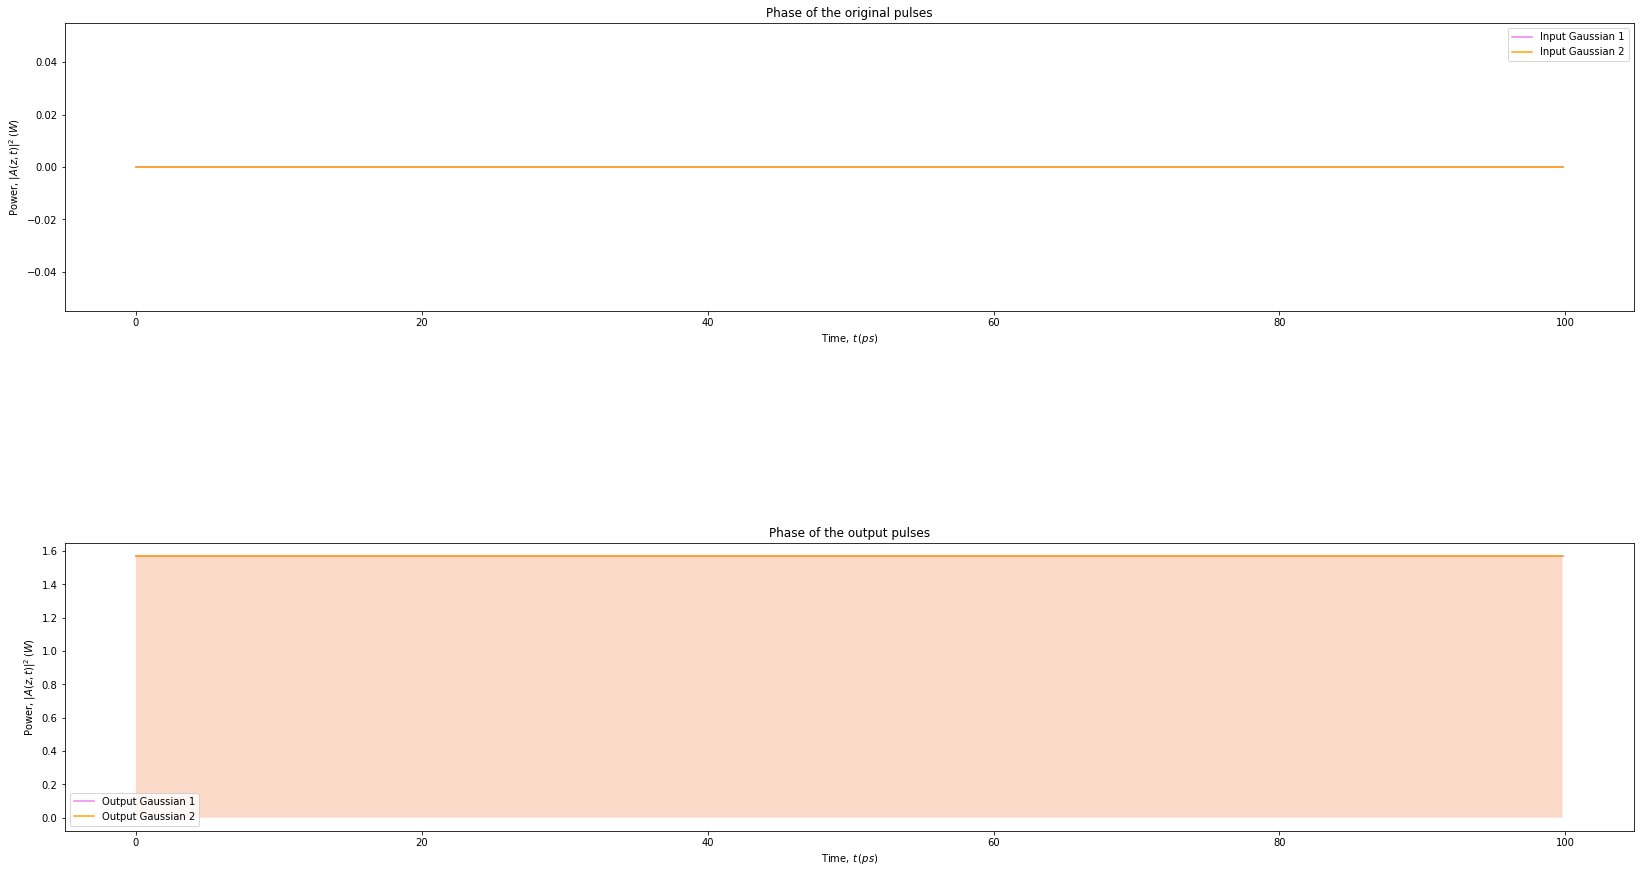

In [45]:
oc.plot2d(time_data, power_data, x_labels=['t'], y_labels=['P_t'], plot_groups=[0,0,1,1],
          plot_titles=['Phase of the original pulses', 'Phase of the output pulses'],
          plot_labels=['Input Gaussian 1', 'Input Gaussian 2', 'Output Gaussian 1', 'Output Gaussian 2'])

We can see the effect the $\frac{pi}{2}$ phase shift.

## End word
This is the end of the first introdution tutorial. The following tutorials will drive you to more complex cases
and components with which you will be able to simulate state of the art optical system !